In [1]:
# general purpose imports
import os
import sys
import numpy as np
import scipy

# SMRT imports
from smrt import make_snowpack, sensor_list, make_model, sensitivity_study
from smrt.utils import dB

# Graphics import
%matplotlib notebook
import matplotlib.pyplot as plt
import smrt.utils.mpl_plots
color = ['#1f77b4','#ff7f0e','#2ca02c','#d62728']

In [2]:
## prepare inputs: snowpack with two layers

temperature = [265]
thickness = [200]
radius0 = 100

phis = np.arange(1, 4, 0.1)

# create the sensor
radiometer = sensor_list.passive(37e9, 55)

<IPython.core.display.Javascript object>


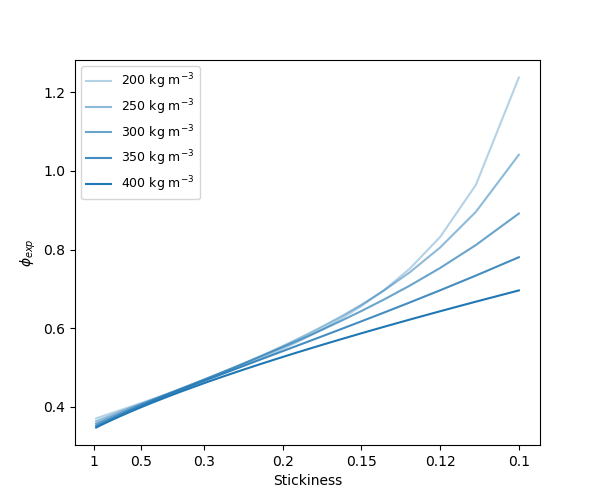

In [3]:
# create the SMRT Model with emmodel="iba"
m_iba = make_model("iba", "dort")
# run the model


def cost_function(phi_exp, TbV_target, density):
    # build a single layer snowpack with stickiness given as input
    corr_length = phi_exp * 4/3 * (1-density/917.0) * radius0*1e-6
    try:
        sp = make_snowpack(thickness, "exponential",
                        density=density, temperature=temperature, corr_length=[corr_length])
        res = m_iba.run(radiometer, sp)
    except smrt.SMRTError:
        return -TbV_target
    return (res.TbV() - TbV_target)  # compute the distance to the target ks

def equivalent_phi(density, stickiness):
    snowpacks = [make_snowpack(thickness, "sticky_hard_spheres",
                            density=[density], temperature=temperature, radius=[radius0*1e-6], stickiness=s) for s in stickiness]

    optimal_phi = []
    for i, snowpack in enumerate(snowpacks):
        em = m_iba.run(radiometer, snowpack)
        try:
            optimal_phi.append( scipy.optimize.brentq(cost_function, 0.2, 3, args=(em.TbV(), density)) )
        except ValueError:
            optimal_phi.append( np.nan )
    return optimal_phi



f, axs =  plt.subplots(1, 1, figsize=(6, 5))
axs = [axs]

stickiness = np.hstack((np.arange(0.1, 0.3, 0.01), np.arange(0.3, 1, 0.05)))

for d in [200, 250, 300, 350, 400]:
    axs[0].plot(stickiness, equivalent_phi(d, stickiness), color=color[0], label='%i kg m$^{-3}$' % d, alpha=(d-100)/300)
    

axs[0].set_xlabel ('Stickiness')
axs[0].set_xscale('stickiness_reciprocal')
axs[0].set_ylabel('$\phi_{exp}$')
axs[0].legend(loc='best')


In [4]:
for ax in axs: ax.legend(loc='best', prop={'size': 9})
#f.savefig("fig_exponential_equivalence.pdf")